In [1]:
import numpy as np
import math
import torch
import torch.optim as optim
import torch.nn.functional as nnf
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image

Необходимые функции

In [2]:
def load_img(path, max_size=400): # функция загрузки картинки в тензор
    img = Image.open(path).convert('RGB')

    size = min(max(img.size), max_size)

    input_trans = transforms.Compose([
        transforms.Resize((size, int(1.5*size))),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.456), (0.229, 0.224, 0.225))
    ])

    img_trans = input_trans(img)[:3, :, :].unsqueeze(0)

    return img_trans


def tensor_to_img(tensor): # преобразование тензора в картинку PIL
    img = tensor.to("cpu").clone().detach()
    img = img.numpy().squeeze()
    img = img.transpose(1, 2, 0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array(
        (0.485, 0.456, 0.406))
    img = img.clip(0, 1)
    out_img = Image.fromarray((img*255).astype(np.uint8))
    return out_img


def get_features(img, model, layers=None): # функция извлечения фичамапов
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    features = {}
    x = img
    for name, layer in enumerate(model.features):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features


def gram_matrix(x): # вычисление матрицы Грама
    batch_size, channels, hgt, wdth = x.size()
    tensor = x.view(channels, hgt*wdth)
    gram = torch.mm(tensor, tensor.t())
    return gram


def generate_mask(shape, num_points: int): # будем создавать маску рандомно на основе диаграммы Вороного
    if num_points > 30: # ограничим количество точек для генерации диаграммы Вороного
        num_points = 30

    points_x = np.random.randint(0, shape[0], num_points)
    points_y = np.random.randint(0, shape[1], num_points)
    points = np.stack((points_x, points_y))
    points_bool = np.random.randint(0, 2, num_points)

    mask = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            min_dist = math.sqrt(shape[0]**2+shape[1]**2)
            for n in range(num_points):
                point = points[:,n]
                dist = math.sqrt(((i - point[0])**2 + (j - point[1])**2))
                if dist < min_dist:
                    min_dist = dist
                    min_index = n
            mask[i,j] = points_bool[min_index]

    return torch.tensor(mask)

Функция стайл трансфера

In [3]:
def style_transfer(model, optimizer, content_img, style1_img, style2_img, output_img, num_iter=400, alpha=1, beta=0.01):
    style_weights = {'conv1_1': 0.3,
                     'conv2_1': 0.5,
                     'conv3_1': 0.3,
                     'conv4_1': 0.2,
                     'conv5_1': 0.2}

    content_features = get_features(content_img, model)
    style1_features = get_features(style1_img, model)
    style2_features = get_features(style2_img, model)

    style1_grams = {
        layer: gram_matrix(style1_features[layer]) for layer in style1_features
    }

    style2_grams = {
        layer: gram_matrix(style2_features[layer]) for layer in style2_features
    }

    mask = generate_mask(shape=content_img.shape[2:], num_points=30).to(device, dtype=torch.float).unsqueeze(0).unsqueeze(0)

    for i in range(1, num_iter+1):
        optimizer.zero_grad()
        target_features = get_features(output_img, model)

        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

        style1_loss = 0
        style2_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            mask_shape = target_feature.shape[2:]
            mask_res = nnf.interpolate(mask, size=mask_shape, mode='bilinear')
            mask_tensor = mask_res[:,0,:,:].expand_as(target_feature)
            target1_gram = gram_matrix(target_feature*mask_tensor)
            target2_gram = gram_matrix(target_feature*(mask_tensor*(-1)+1))
            _, channels, hgt, wdth = target_feature.shape
            style1_gram = style1_grams[layer]
            style2_gram = style2_grams[layer]
            layer_style1_loss = style_weights[layer] * torch.mean((target1_gram - style1_gram) ** 2)
            layer_style2_loss = style_weights[layer] * torch.mean((target2_gram - style2_gram) ** 2)

            style1_loss += layer_style1_loss / (channels * hgt * wdth)
            style2_loss += layer_style2_loss / (channels * hgt * wdth)


        total_loss = alpha * content_loss + beta * (style1_loss + style2_loss)
        total_loss.backward(retain_graph=True)
        optimizer.step()

        if i % 50 == 0:
            total_loss_rounded = round(total_loss.item(), 2)
            content_fraction = round(alpha * content_loss.item() / total_loss.item(), 2)
            style1_fraction = round(beta * style1_loss.item() / total_loss.item(), 2)
            style2_fraction = round(beta * style2_loss.item() / total_loss.item(), 2)
            print('Iteration {}, Total loss: {} - (content: {}, style1: {}, style2: {})'.format(
                i, total_loss_rounded, content_fraction, style1_fraction, style2_fraction))

    final_img = tensor_to_img(output)

    return final_img, mask

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vgg19(pretrained=True).to(device).eval()

for param in model.parameters():
    param.requires_grad_(False)

Картинка содержания

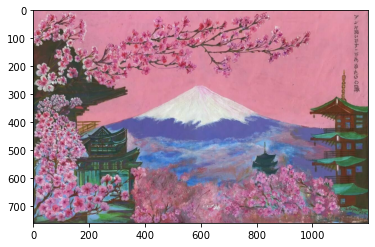

In [5]:
content_im = Image.open('contents/content1.jpg')
plt.imshow(content_im);

Картинки стилей

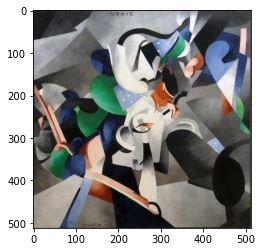

In [6]:
style1_im = Image.open('styles/style2.jpg')
plt.imshow(style1_im);

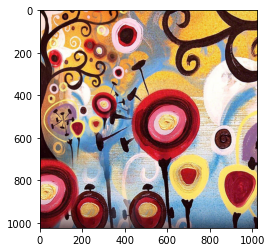

In [7]:
style2_im = Image.open('styles/style3.jpg')
plt.imshow(style2_im);

Загрузка картинок в тензоры и обработка

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\torch\nn\functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Iteration 50, Total loss: 8.67 - (content: 0.29, style1: 0.16, style2: 0.54)
Iteration 100, Total loss: 6.72 - (content: 0.34, style1: 0.16, style2: 0.5)
Iteration 150, Total loss: 6.07 - (content: 0.36, style1: 0.16, style2: 0.48)
Iteration 200, Total loss: 5.69 - (content: 0.37, style1: 0.16, style2: 0.47)
Iteration 250, Total loss: 5.44 - (content: 0.38, style1: 0.16, style2: 0.46)
Iteration 300, Total loss: 5.25 - (content: 0.38, style1: 0.16, style2: 0.46)
Iteration 350, Total loss: 5.14 - (content: 0.39, style1: 0.16, style2: 0.45)
Iteration 400, Total loss: 5.03 - (content: 0.4, style1: 0.16, style2: 0.44)


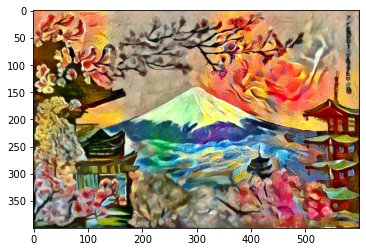

In [8]:
content = load_img('contents/content1.jpg').to(device, dtype=torch.float)
style1 = load_img('styles/style2.jpg').to(device, dtype=torch.float)
style2 = load_img('styles/style3.jpg').to(device, dtype=torch.float)

output = content.clone().to(device).detach().requires_grad_(True)

adam = optim.Adam([output], lr=0.1)

result, mask = style_transfer(model, adam, content, style1, style2, output, num_iter=400, alpha=1, beta=0.1)
result.save('results/result1.jpg')
plt.imshow(result);

Маска стилей

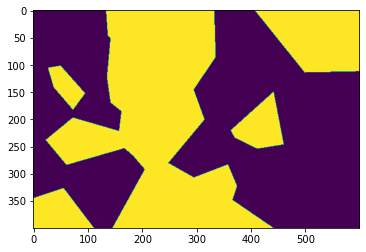

In [9]:
plt.imshow(mask.cpu().squeeze().squeeze());